In [2]:
import tensorflow as tf
import keras
import retina
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(retina.filesys.TRAINING_DATA_CSV_PATH, index_col=False)
labels = df["label"]
df = df.drop(columns=["label"])
df

,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,feature-10,feature-11,feature-12,feature-13,feature-14,feature-15,feature-16,feature-17,feature-18,feature-19,feature-20
0,0.437019,0.042334,0.278261,-0.045249,0.330148,0.107846,-0.099355,-0.110393,0.001492,0.081777,-0.039452,-0.072168,-0.022999,0.085455,0.005391,0.026204,-0.038239,-0.089844,-0.001910,0.015836
1,0.773598,-0.551340,0.018452,0.117957,-0.057331,-0.111263,-0.114178,-0.100482,-0.139121,0.028774,0.099674,0.047380,0.088874,-0.017566,-0.050332,-0.027480,-0.035212,-0.059877,-0.001171,-0.040191
2,-0.676542,0.232889,0.159456,0.361651,0.420816,0.177084,-0.040109,0.055711,-0.078223,-0.031659,0.051370,-0.006509,0.078527,-0.013015,0.003992,-0.026705,-0.020189,-0.074122,0.004513,0.026379
3,2.288088,-0.838301,-0.420766,0.069825,-0.241442,0.189276,0.107825,-0.154459,-0.218951,0.125552,0.043605,0.024234,0.034919,-0.008680,-0.037126,0.077481,-0.052466,-0.013246,0.020170,-0.009308
4,4.159304,-0.584385,-0.365329,-0.909574,-0.107999,0.401006,-0.392267,0.047713,-0.011645,0.003072,-0.125918,0.010903,0.036357,0.077545,0.031963,-0.014358,-0.026200,-0.048401,-0.044011,-0.007343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,0.305254,0.624060,-0.139793,0.030221,-0.054872,-0.351809,0.016603,-0.008458,-0.076875,0.018991,0.026324,0.065919,0.000878,-0.010469,-0.041997,-0.002832,-0.023856,0.032153,-0.007929,0.001368
408,0.657566,0.768659,0.349452,0.070217,-0.059507,-0.298525,0.076423,0.016585,-0.036243,-0.004279,-0.002439,0.062077,-0.012194,-0.005436,0.000312,0.059433,-0.024865,-0.014034,-0.015162,0.042888
409,1.172339,0.290520,0.122668,0.048162,-0.116668,-0.351048,-0.046663,-0.058944,-0.128811,-0.054530,-0.009227,0.059848,-0.004938,-0.043396,-0.090148,0.094614,-0.027410,-0.000811,0.009935,0.016397
410,1.559539,0.475793,-0.548418,0.079219,0.026244,-0.403257,0.014065,-0.117838,-0.009810,-0.045036,-0.041057,0.057582,0.060541,0.002797,-0.038937,0.029685,0.039684,-0.019349,-0.042302,0.021548


In [4]:
dataset = tf.data.Dataset.from_tensor_slices((df, labels))
train_dataset, test_dataset = keras.utils.split_dataset(dataset, shuffle=True, seed=42, left_size=0.7)
train_dataset, validation_dataset = keras.utils.split_dataset(train_dataset, shuffle=True, seed=42, left_size=0.7)

train_dataset = train_dataset.repeat(5).shuffle(100).batch(16)
test_dataset = test_dataset.batch(16)
validation_dataset = validation_dataset.batch(16)

dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(20,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [5]:
model = keras.Sequential([
  keras.layers.Input(shape=dataset.element_spec[0].shape),
  keras.layers.Dense(100, activation="sigmoid"),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(500, activation="sigmoid"),
  keras.layers.Dense(6),
  keras.layers.Softmax(),
])

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.005), # type: ignore
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"],
)

In [10]:
history = model.fit(
  train_dataset, epochs=20,
  validation_data=validation_dataset,
  # callbacks=keras.callbacks.EarlyStopping(
  #   monitor='val_loss',
  #   min_delta=0,
  #   patience=2,
  #   verbose=0,
  #   mode='auto'
  # )
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4940 - loss: 1.3196 - val_accuracy: 0.4419 - val_loss: 1.3990
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4979 - loss: 1.3043 - val_accuracy: 0.4419 - val_loss: 1.4276
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5127 - loss: 1.2706 - val_accuracy: 0.4186 - val_loss: 1.4903
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5503 - loss: 1.2316 - val_accuracy: 0.4302 - val_loss: 1.4127
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5619 - loss: 1.1854 - val_accuracy: 0.4419 - val_loss: 1.3695
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5504 - loss: 1.1389 - val_accuracy: 0.4767 - val_loss: 1.4371
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5611 - loss: 1.1612 - val_accuracy: 0.5000 - val_loss: 1.3439
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5773 - loss: 1.1146 - val_accuracy: 0.4651 - val_los

In [11]:
model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6013 - loss: 1.4575


[1.5687918663024902, 0.5403226017951965]

In [12]:
model.save(retina.filesys.EXPRESSION_RECOGNITION_MODEL_PATH)

C:\Users\Davin Tristan\AppData\Local\Temp\ipykernel_3416\469801421.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  accuracy_fig.show()


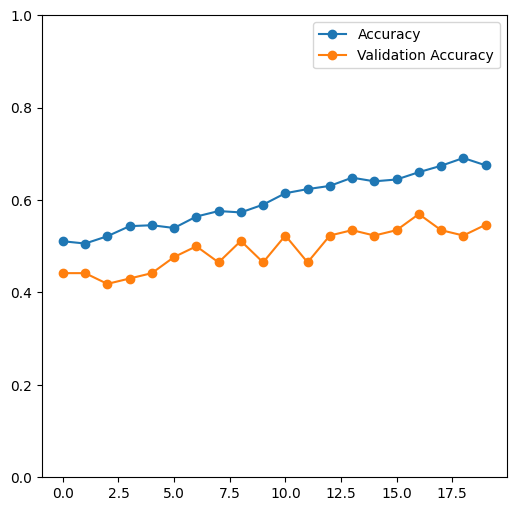

In [13]:
accuracy_fig = plt.figure(figsize=(6,6))
ax = accuracy_fig.add_subplot()
ax.plot(history.history["accuracy"], label="Accuracy", marker='o')
ax.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='o')
ax.legend()
ax.set_ylim(0, 1)
accuracy_fig.show()